# Notebook MENB

# Introduction

## Packagese needed

All the packages needed are specified:

In [1]:
using Serialization
using PyPlot
using Distributions
using DelimitedFiles

In [2]:
include(joinpath(@__DIR__, "Notebook_Functions.jl"));
include(joinpath(@__DIR__, "MENB/infer_hosts.jl"));

# Section 1: 
# Assigning probabilities to any sequence from already learnt MENB models

## 1.1 Models importation and specifications

And the learnt models: "SavedModels/MENB-HGV.bin" which are made avaiable and can 

In [3]:
#Model MENB-H
 Model_H = open(joinpath(@__DIR__, "TrainedModels/MENB-H.bin" ), "r") do file
    deserialize(file)
end;
#Model MENB-H|V and MENB-H,V
Model_HV = open(joinpath(@__DIR__, "TrainedModels/MENB-HGV.bin" ), "r") do file
    deserialize(file)
end;

### 1.1.1 MENB-H|V, MENB-H,V

The models imported have been organized as a nested vector (vector of vectors)  schematically organized as follows:
$$\textbf{Model-HV[\textcolor{Blue}{Binary Depth}][\textcolor{Green}{Host}][\textcolor{Orange}{Virus}][\textcolor{purple}{Binary element}][\textcolor{Brown}{Seed}]}$$
$\textcolor{Red}{1)}$ $\textbf{Depth of Binary Division}$:
    each vector element corresponds to the depth of the binary division of genomes, in order: $\textit{Full lengths, Halves, Fourths, Eights and Sixteenths}.$
    $$\textbf{Model-HV[\textcolor{blue}{i}] }\ \ \ \ \ for \ i \ in \  1,..., N_{depth}, \ ( where \ \textcolor{blue}{N_{depth}=5})$$
$\textcolor{Red}{2)} $ $\textbf{Host}$: Indexes refers to the hosts considered in the analysis, in order: $\textit{Avian, Human, Swine}$.
    $$\textbf{Model-HV[\textcolor{blue}{i}][\textcolor{green}{j}]} \ \ \ \ \ for \ j \ in \  1,..., N_{host},  \ ( where \ \textcolor{green}{N_{host}=3}) $$
$\textcolor{Red}{3)} $ $\textbf{Virus}$:
    vector of the viral family under study: $\textit{Coronaviridae, Flaviviridae, Picornaviridae and Orthomyxoviridae}$ respectively.
    $$\textbf{Model-HV[\textcolor{blue}{i}][\textcolor{green}{j}][\textcolor{orange}{k}]} \ \ \ \ \ for \ k \ in \  1,...,N_{virus},  \ ( where \ \textcolor{orange}{N_{virus}=4})$$
$\textcolor{Red}{4)} $ $\textbf{Binary element}$:
    For the given binary depth $\textcolor{blue}{i}$, all the partitions are considered in order.
    $$\textbf{Model-HV[\textcolor{blue}{i}][\textcolor{green}{j}][\textcolor{orange}{k}][\textcolor{purple}{m}]} \ \ \ \ \ for \ m \ in \  1,...,N_{segment},  \ ( where \ \textcolor{purple}{N_{segment}=2^{i}})$$
$\textcolor{Red}{5)} $ $\textbf{Seed}$:This last index accounts for the 3 sub-samples (equivalent to three learnt models) which have been used to avarage results.
    $$\textbf{Model-HV[\textcolor{blue}{i}][\textcolor{green}{j}][\textcolor{orange}{k}][\textcolor{purple}{m}][\textcolor{brown}{n}]} \ \ \ \ \ for \ n \ in \  1,...,N_{seed},  \ ( where \textcolor{brown}{\ N_{seed}=3})$$

### 1.1.2 MENB-H

The variable organization is very similar to the one described above, with the only difference of not having any index for the viral family (since sequences have been grouped together based on the host infected and independenlty form the viral families). Therefore:

$$\textbf{Model-H[\textcolor{Blue}{Binary Depth}][\textcolor{Green}{Host}][\textcolor{purple}{Binary element}][\textcolor{Brown}{Seed}]}$$

## 1.2 Constant definition of quantities

For the following notebook we will focus on scoring sequences using full genomes. Additionally constraining to the hosts and viruses already mentioned, all of this entails the following constant quantities:


In [4]:
#Full genome considered (Binary division of depth 0), First (and only element) of the binary division 
const i, m= 1, 1
#Vector containing the labels (Strings) of the viral families under study
const v=["Corona", "Flavi", "Picorna", "Orthomyxo"]; 
#Vector of colors used to plot assigned probability from MENB models (for viruses in order of "v")
const colors_virus=["pink","yellowgreen", "mediumturquoise", "gold"]; 
#Vector containing the labels (Strings) of hosts under study
const h=["avian", "human", "swine" ];
#Vector of colors used to plot assigned probability from MENB models (for hosts, in order of "h")
const colors_host=["salmon","peachpuff",  "lightskyblue"] 
#Ranging indexes as schematically presented
const N_depth,N_host, N_virus, N_segment, N_seed=5, 3, 4, 2^i, 3;

Finally we consider the alphabet for sequences in a generic dataset. $\textit{Withouth loss of generality},$ the DNA representation will be used (RNA sequences will be processed automatically, transoforming 'U' characters in 'T').

In [5]:
#Nucleotide alphabet used
const dna_alphabet = ["A", "C", "G", "T"];

## 1.3 Dictionaries for the models

To assign probabilities to a given set of sequences, Dictionaries containing the labels of the learnt models need to be constructed.

### 1.3.1 Dictionary MENB-H|V

MENB-H|V models can be applied to test sequences belonging to the same viral families of the training set. Dictionary variable will be organized as vector of sub-samples considered and dictionaries of NucleotideModel type for each host at fixed viral family as keys:
$$\textbf{Dict-H|V[\textcolor{brown}{Seed}][ \textcolor{orange}{"Label virus"}, \textcolor{greEn}{"Label host"}]}$$
$$  where \ {"Label \ virus"}=v[\textcolor{orange}{k}] \ given \ \{k \ in \ 1,..., \textcolor{orange}{N_{virus}}\} \ and \ {"Label \ hosts"} \in \{h[\textcolor{green}{j}] \ for \ j \ in \ 1,..., \textcolor{green}{N_{hosts}}\} $$ 
The total number of dictionaries will be: 
$${N_{Dic-H|V}}=\textcolor{brown}{N_{seed}} \cdot \textcolor{green}{N_{host}}$$


The input model must be in the format: 
$$\textbf{Model-H|V-input[\textcolor{green}{Host}][\textcolor{brown}{Seed}]}, \ \ \ \ at \ fixed \ \textcolor{blue}{i}, \textcolor{orange}{k}, \textcolor{purple}{m}$$

For this example we fix at the viral family: $Coronaviridae$

In [6]:
#Fixing Viral Family
k=1;

In [7]:
Model_HgV_input=[Model_HV[i][1][k][m], Model_HV[i][2][k][m], Model_HV[i][3][k][m]];

In [8]:
Dict_HgV=Seed_Model_Dictionary(Model_HgV_input, k);

### 1.3.2 Dictionary MENB-H,V

MENB-H,V models can be applied to test unlabelled sequences. Dictionary will be organized as vector of sub-samples considered and dictionaries of NucleotideModel type for each host and viral family as keys:
$$\textbf{Dict-H,V[\textcolor{brown}{Seed}][ \textcolor{orange}{"Label virus"}, \textcolor{greEn}{"Label host"}]}$$
$$  where \ {"Label \ virus"} \in \{ v[\textcolor{orange}{k}] \ for \ k \ in \ 1,..., \textcolor{orange}{N_{virus}}\} \ and \ {"Label \ hosts"} \in \{h[\textcolor{green}{j}] \ for \ j \ in \ 1,..., \textcolor{green}{N_{hosts}}\} $$ 
The total number of dictionaries will be: 
$${N_{Dic-H,V}}=\textcolor{brown}{N_{seed}} \cdot \textcolor{green}{N_{host}} \cdot \textcolor{orange}{N_{virus}} $$

The input model must be in the format: 
$$\textbf{Model-H|V-input[\textcolor{green}{Host}][\textcolor{orange}{Virus}][\textcolor{brown}{Seed}]}, \ \ \ \ at \ fixed \ \textcolor{blue}{i}, \textcolor{purple}{m}$$

In [9]:
#To do so here we fix the binary depth, while the segment will be fixed in the function by passing a Boolean variable as true
Model_HaV_input=Model_HV[i];

In [10]:
Dict_HaV= Seed_Model_Dictionary_HV(Model_HaV_input; i, m, verbose=true);

### 1.3.3 Dictionary MENB-H

MENB-H models, as MENB-H,V, can be applied to test unlabelled sequences. Dictionary will be organized as vector of sub-samples considered and dictionaries of NucleotideModel type for each host, independetly of the viral family, used as keys:
$$\textbf{Dict-H[\textcolor{brown}{Seed}][  \textcolor{greEn}{"Label host"}]}$$
$$  where  \ {"Label \ hosts"} \in \{h[\textcolor{green}{j}] \ for \ j \ in \ 1,..., \textcolor{green}{N_{hosts}}\} $$ 
The total number of dictionaries will be: 
$${N_{Dic-H}}=\textcolor{brown}{N_{seed}} \cdot \textcolor{green}{N_{host}} $$

The input model must be in the format: 
$$\textbf{Model-H-input[\textcolor{green}{Host}][\textcolor{brown}{Seed}]}, \ \ \ \ at \ fixed \ \textcolor{blue}{i}, \textcolor{purple}{m}$$

In [11]:
#Here we fix i before and m in the function by passing a true Boolean variable 
Model_H_input=Model_H[i];

In [12]:
Dict_H=Seed_Model_Dictionary_H(Model_H_input; m, verbose=true);

## 1.4 Scoring and Plotting Results

At this point any file, consisting of sequences (DNA or RNA) can be used by the reader to apply the already learnt model for thei specific purposes and analyis.
Here fors the sake of simplicity a set of 7 random sequences are used:

In [13]:
#This has to be changed with real genomes from the virus/host considered to test for specific readers analysis
TestRandomSet = convert(Vector{String},vcat(readdlm("Datasets/TestRandomSet.txt")...));

### 1.4.1 Probability assigned by MENB-H|V

In [14]:
Prob_hosts=Probabilities_HV1(TestRandomSet, Dict_HgV);

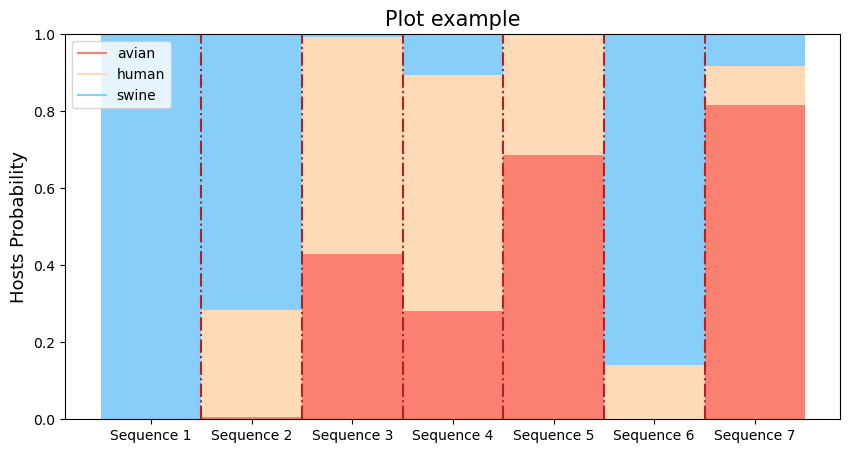

In [15]:
Plot_Seqs_Probabilities(N_host, Prob_hosts, colors_host, h)

### 1.4.2 Probability assigned by MENB-H,V

In [16]:
Hosts, Virus=Probabilities_HV2(TestRandomSet, Dict_HaV; verbose=true);

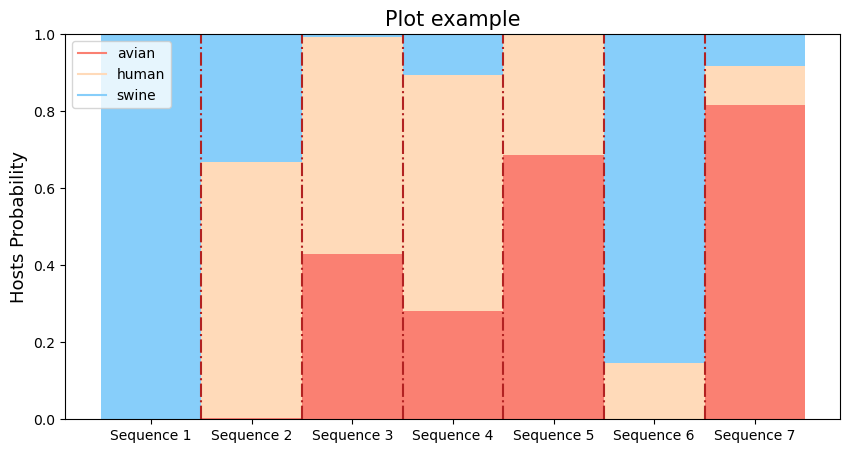

In [17]:
Plot_Seqs_Probabilities(N_host, Hosts, ["salmon","peachpuff",  "lightskyblue"], h)

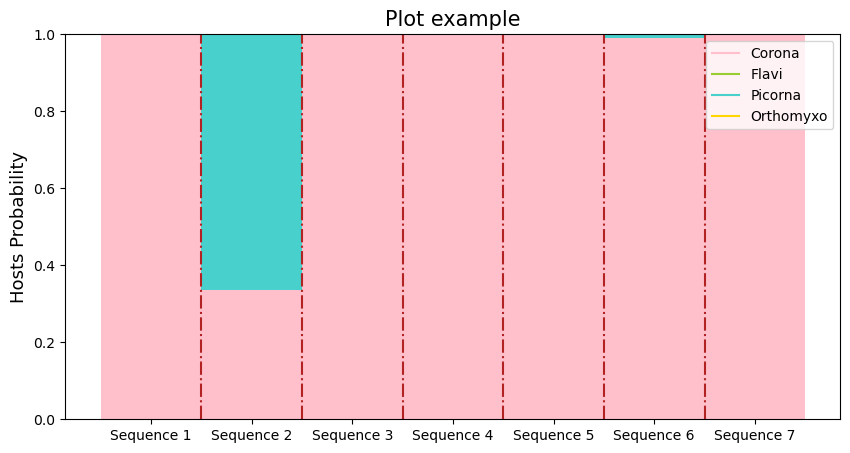

In [18]:
Plot_Seqs_Probabilities(N_virus, Virus, colors_virus, v)

### 1.4.3 Probability assigned by MENB-H

In [19]:
Prob_H=Probabilities_H(TestRandomSet, Dict_H);

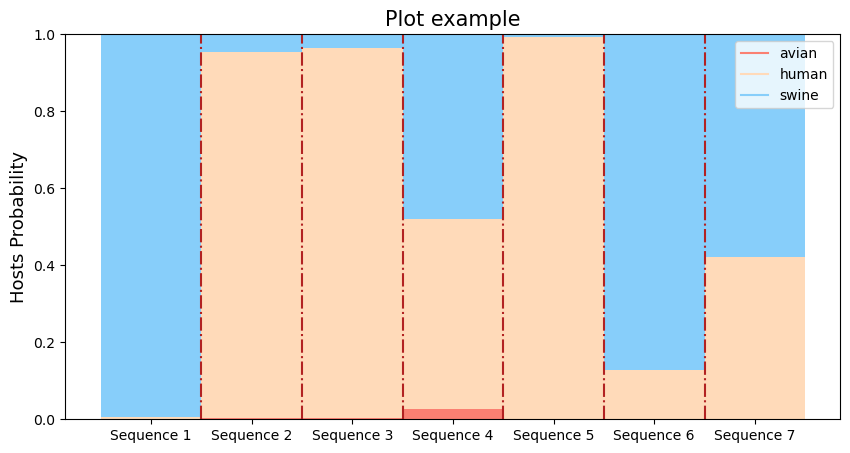

In [20]:
Plot_Seqs_Probabilities(N_host, Prob_H, colors_host, h)

# Section 2
# Generalization to readers usage

## 2.1 Train

In [21]:
#Vector of Strings (or single String)
#To change with readers own new datasets
TrainingDataset = convert(Vector{String}, vcat(readdlm("Datasets/TrainingDatasets.txt")...));

In [22]:
ModelTrained=Main.MaxEntNucleotideBiases.fitmodel(TrainingDataset, 3, 1000)

MaxEntNucleotideBiases.NucleotideModel(["A", "C", "G", "AA", "AC", "AG", "CA", "CC", "CG", "GA"  …  "TCG", "TCT", "TGA", "TGC", "TGG", "TGT", "TTA", "TTC", "TTG", "TTT"], [-0.5169498787560234, 0.35095651609578715, 0.8616912716234426, 0.32213139569344085, -0.0565109386531048, -0.08989503659948295, -0.09428213236884202, 0.07613252663717196, -0.027696225885469106, -0.17474694233448995  …  0.0434745324123286, -0.14213761485592935, 0.156978583416308, 0.07113300747008994, -0.05438500131006657, -0.1737265895763314, -0.1960446527035804, 0.04840966443867396, 0.03449775571471772, 0.11313723255018872], 3)

## 2.2 Generating Artificial Sequences

In [23]:
Nseq=10
ArtificialSequences=[join(Main.MaxEntNucleotideBiases.sample_metropolis(1500, ModelTrained)) for _ in 1:Nseq];

## 2.3 Score

### 2.3.1 Redefinition of constants

Warnings will appear, as constant values are being redefined.

In [24]:
#Vector containing the labels (Strings) of the viral families under study
const v=["Virus 1", "Virus 2"]; 
#Vector of colors used to plot assigned probability from MENB models (for viruses in order of "v")
const colors_virus=["pink","yellowgreen"]; 
#Vector containing the labels (Strings) of hosts under study
const h=["host 1", "host 2", "host 3", "host 4"];
#Vector of colors used to plot assigned probability from MENB models (for hosts, in order of "h")
const colors_host=["salmon","peachpuff",  "lightskyblue", "palegreen"] 
#Ranging indexes as schematically presented
const N_host, N_virus, N_seed=4, 2, 1
#This redefinition of constants will display warning
;

We define some additional quantities for this examples, but once again they can be modified for thei ows purposes:

In [25]:
#Number of mers used to train the MENB models, they can be choseen from 1,2 or 3
const Lmotifs=3 
#Setting a constant length to all sequences in training sets (in case different lengths are present)
const Lmodel=1000;

### 2.3.2 Datasets 

We consider here random set of 10 sequences, but they should be modified with real datasets which are wanted to be studied.

In this section we will modify the general setting of hosts and setting, to guide the reader to use it in their own cases. For this reason we will change the constant quantities defined before in a new case in which there are only 2 viruses but 4 hosts, and only 1 sample is considered (equivalent to not avareging results).


In [26]:
#To change with readers own dataset to analyze
Host1_Virus1=convert(Vector{String},vcat(readdlm("Datasets/Host1_Virus1.txt")...));
Host2_Virus1=convert(Vector{String},vcat(readdlm("Datasets/Host2_Virus1.txt")...));
Host3_Virus1=convert(Vector{String},vcat(readdlm("Datasets/Host3_Virus1.txt")...));
Host4_Virus1=convert(Vector{String},vcat(readdlm("Datasets/Host4_Virus1.txt")...));

Host1_Virus2=convert(Vector{String},vcat(readdlm("Datasets/Host1_Virus2.txt")...));
Host2_Virus2=convert(Vector{String},vcat(readdlm("Datasets/Host2_Virus2.txt")...));
Host3_Virus2=convert(Vector{String},vcat(readdlm("Datasets/Host3_Virus2.txt")...));
Host4_Virus2=convert(Vector{String},vcat(readdlm("Datasets/Host4_Virus2.txt")...));

In [27]:
Host1=vcat(Host1_Virus1, Host1_Virus2)
Host2=vcat(Host2_Virus1, Host2_Virus2)
Host3=vcat(Host3_Virus1, Host3_Virus2)
Host4=vcat(Host4_Virus1, Host4_Virus2);

### 2.3.3 Ordering Datasets

In [28]:
Train_HV=[Host1_Virus1,Host1_Virus2, Host2_Virus1, Host2_Virus2, Host3_Virus1, Host3_Virus2, Host4_Virus1, Host4_Virus2]
Train__H=[Host1, Host2, Host3, Host4];

In [29]:
Train_HgV=order_HgV(Train_HV, 1)
Train_HaV=order_HaV(Train_HV)
Train_H=order_H(Train__H);

### 2.3.4 Learngin models

For the training data must be organized as for the Dictionary: 
Seed, Host.
Here we will focus on the first Virus. Since there is only 1 seed:

In [30]:
Models_HgV=train_ordered_sets(Train_HgV, Lmotifs, Lmodel)
Models_HaV=train_ordered_sets_HaV(Train_HaV, Lmotifs, Lmodel);
Models_H=train_ordered_sets_H(Train_H,Lmotifs, Lmodel);

### 2.3.5 Dictionaries

In [31]:
Dict_HgV=Seed_Model_Dictionary(Models_HgV, 1)
Dict_HaV=Seed_Model_Dictionary_HV(Models_HaV; i, m, verbose=false);
Dict_H=Seed_Model_Dictionary_H(Models_H; m, verbose=false);

BoundsError: BoundsError: attempt to access 1-element Vector{Any} at index [2]

### 2.3.6 Assigning Probabilities

In [32]:
Prob_hosts_HgV=Probabilities_HV1(TestRandomSet, Dict_HgV);
Prob_hosts_HaV, Prob_virus=Probabilities_HV2(TestRandomSet, Dict_HaV; verbose=true);
Prob_hosts_HaV, Prob_virus=Probabilities_H(TestRandomSet, Dict_H);

BoundsError: BoundsError: attempt to access 1-element Vector{Any} at index [2]

### 2.3.7 Plotting example

In [33]:
Plot_Seqs_Probabilities(N_virus, Prob_virus, colors_virus, v)

UndefVarError: UndefVarError: `Prob_virus` not defined